In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree # importing the tree module from sklearn
from sklearn import metrics # importing the metrics module from sklearn
from sklearn.model_selection import train_test_split # importing the train_test_split function from sklearn's model_selection module
import numpy as np

In [2]:
X = pd.read_csv('data/News_dataset/X_train_scaled.csv')
y = pd.read_csv('data/News_dataset/y_train.csv')

print(X.head())
#convert to 1D
y = y['label']

# Convert pandas DataFrames/Series to numpy arrays
X = X.values  # Converts the features to a numpy array
y = y.values  # Converts the target to a numpy array

# Convert 'Fake' to 0 and 'True' to 1
y = np.where(y == 'True', 1, 0)

   text_length  title_length  length_phrases_no_punctuation_text  \
0     0.394864      0.214286                           -0.837787   
1    -0.590155      0.535714                           -0.478777   
2     0.420011      0.071429                           -0.553995   
3     2.319957     -0.035714                            0.792021   
4    -0.022472      0.250000                           -0.278197   

   length_phrases_no_punctuation_title  qtt_numbers  qtt_noms_propis  \
0                                  0.2        3.000            0.725   
1                                  0.6        0.000           -0.300   
2                                  0.2        0.000            0.000   
3                                  0.2       -0.125            1.775   
4                                  0.2       -0.250            0.350   

   qtt_punt  stopwords  emotional  repeated  capital_title  reference_count  \
0  1.341463   0.279720        0.0       1.0       0.272727              0.5   


In [3]:
X.shape

(40399, 20)

### començarem amb logistic regression, dsps farem random forest and descision trees i per últim farem svm ( suport vector machine) + optional naive bayes

# cross validation

### LOGISTIC REGRESSION

In [9]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import numpy as np
from collections import defaultdict

# Dictionary to store the best hyperparameters from each outer fold
params_scores = defaultdict(list)

# Define the outer cross-validation (outer loop) - 5 folds
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the inner cross-validation (inner loop) - 3 folds
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the model and hyperparameter grid for Logistic Regression
model = LogisticRegression(max_iter=1000, solver='liblinear')  # 'liblinear' works well for binary classification
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'model__penalty': ['l1', 'l2']        # Regularization type
}

# To store the results from the outer loop
outer_scores = []

# Outer loop: iterating through each fold of the outer cross-validation
for train_idx, test_idx in outer_cv.split(X):
    # Split the data into training and testing sets for the current outer fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Create a pipeline to standardize the data and fit the logistic regression model
    pipeline = Pipeline([
        ('scaler', RobustScaler()), # to avoid data leakage 
        ('model', LogisticRegression(max_iter=1000, solver='liblinear'))
    ])
    
    # Perform grid search within the inner loop
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train) #SEARCH WHAT DOES GRID SEARCH

    # Store the best hyperparameters and their score for this fold
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    for param, value in best_params.items():
        params_scores[param].append(value)
    
    # Evaluate the best model found by GridSearchCV on the outer test set
    best_model = grid_search.best_estimator_
    outer_score = best_model.score(X_test, y_test)
    outer_scores.append(outer_score)

# Calculate the most frequent set of hyperparameters
final_best_params = {}
for param, values in params_scores.items():
    final_best_params[param] = max(set(values), key=values.count)

print(f"Final Best Hyperparameters: {final_best_params}")
# Calculate the mean and standard deviation of the outer scores
mean_score = np.mean(outer_scores)
std_score = np.std(outer_scores)

print(f"Nested CV Accuracy: {mean_score:.3f} ± {std_score:.3f}")


Final Best Hyperparameters: {'model__C': 10, 'model__penalty': 'l1'}
Nested CV Accuracy: 0.988 ± 0.001


In [10]:
outer_scores

[0.9867574257425743,
 0.988490099009901,
 0.9889851485148515,
 0.9889851485148515,
 0.9886124520361431]

In [11]:
params_scores

defaultdict(list,
            {'model__C': [10, 10, 10, 10, 100],
             'model__penalty': ['l1', 'l2', 'l1', 'l1', 'l1']})

In [12]:
X_test = pd.read_csv('data/News_dataset/X_test_scaled.csv')
y_test = pd.read_csv('data/News_dataset/y_test.csv')

X_test = X_test.values  # Converts the features to a numpy array
y_test = y_test.values  # Converts the target to a numpy array

# Convert 'Fake' to 0 and 'True' to 1
y_test = np.where(y_test == 'True', 1, 0)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)


final_model = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    C=final_best_params['model__C'],
    penalty=final_best_params['model__penalty']
)

# Fit the final model on the entire dataset
final_model.fit(X, y) #90% sencer de les dades, ouput de l'outlier detection notebook

# Predict using the final model
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Save the final model if needed
import joblib
joblib.dump(final_model, 'final_logistic_regression_model.pkl')

Accuracy: 0.521
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
ROC-AUC Score: 0.500


/Users/paucolomercoll/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['final_logistic_regression_model.pkl']

### RANDOM FOREST

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from collections import defaultdict
import numpy as np

# Dictionary to store the best hyperparameters from each outer fold
params_scores = defaultdict(list)

# Define the outer cross-validation (outer loop) - 5 folds
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the inner cross-validation (inner loop) - 3 folds
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the model and hyperparameter grid for Random Forest
model = RandomForestClassifier(random_state=42)
param_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'model__max_depth': [None, 10, 20, 30], # Maximum depth of each tree
    'model__min_samples_split': [2, 5, 10], # Minimum samples required to split a node
    'model__min_samples_leaf': [1, 2, 4],   # Minimum samples required at each leaf node
}

# To store the results from the outer loop
outer_scores = []

# Outer loop: iterating through each fold of the outer cross-validation
for train_idx, test_idx in outer_cv.split(X):
    # Split the data into training and testing sets for the current outer fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Create a pipeline to standardize the data and fit the random forest model
    pipeline = Pipeline([
        ('scaler', RobustScaler()),              # to avoid data leakage 
        ('model', RandomForestClassifier(random_state=42))
    ])
    
    # Perform grid search within the inner loop
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store the best hyperparameters and their score for this fold
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    for param, value in best_params.items():
        params_scores[param].append(value)
    
    # Evaluate the best model found by GridSearchCV on the outer test set
    best_model = grid_search.best_estimator_
    outer_score = best_model.score(X_test, y_test)
    outer_scores.append(outer_score)

# Calculate the most frequent set of hyperparameters
final_best_params = {param: max(set(values), key=values.count) for param, values in params_scores.items()}

print(f"Final Best Hyperparameters: {final_best_params}")
# Calculate the mean and standard deviation of the outer scores
mean_score = np.mean(outer_scores)
std_score = np.std(outer_scores)

print(f"Nested CV Accuracy: {mean_score:.3f} ± {std_score:.3f}")


Final Best Hyperparameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Nested CV Accuracy: 0.995 ± 0.000


In [15]:
outer_scores

[0.9945544554455445,
 0.995049504950495,
 0.996039603960396,
 0.9952970297029703,
 0.995296447580146]

In [16]:
params_scores

defaultdict(list,
            {'model__max_depth': [None, 20, 20, 20, 20],
             'model__min_samples_leaf': [1, 1, 1, 1, 1],
             'model__min_samples_split': [2, 5, 2, 2, 2],
             'model__n_estimators': [200, 50, 100, 50, 200]})

In [17]:
X_test = pd.read_csv('data/News_dataset/X_test_scaled.csv')
y_test = pd.read_csv('data/News_dataset/y_test.csv')

X_test = X_test.values  # Converts the features to a numpy array
y_test = y_test.values  # Converts the target to a numpy array

# Convert 'Fake' to 0 and 'True' to 1
y_test = np.where(y_test == 'True', 1, 0)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import joblib

# Define the final model using the best hyperparameters found
final_model = RandomForestClassifier(
    n_estimators=final_best_params['model__n_estimators'],
    max_depth=final_best_params['model__max_depth'],
    min_samples_split=final_best_params['model__min_samples_split'],
    min_samples_leaf=final_best_params['model__min_samples_leaf'],
    random_state=42
)

# Fit the final model on the entire training dataset
final_model.fit(X, y)

# Predict using the final model on the test dataset
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Save the final model
joblib.dump(final_model, 'final_random_forest_model.pkl')


Accuracy: 0.521
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
ROC-AUC Score: 0.500


/Users/paucolomercoll/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['final_random_forest_model.pkl']

### SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from collections import defaultdict
import numpy as np

# Dictionary to store the best hyperparameters from each outer fold
params_scores = defaultdict(list)

# Define the outer cross-validation (outer loop) - 5 folds
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the inner cross-validation (inner loop) - 3 folds
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the model and hyperparameter grid for SVM
model = SVC()
param_grid = {
    'model__C': [0.1, 1, 10, 100],            # Regularization parameter
    'model__kernel': ['linear', 'rbf'],       # Kernel type
    'model__gamma': ['scale', 'auto']         # Kernel coefficient
}

# To store the results from the outer loop
outer_scores = []

# Outer loop: iterating through each fold of the outer cross-validation
for train_idx, test_idx in outer_cv.split(X):
    # Split the data into training and testing sets for the current outer fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Create a pipeline to standardize the data and fit the SVM model
    pipeline = Pipeline([
        ('scaler', RobustScaler()),              # Standardize features
        ('model', SVC())
    ])
    
    # Perform grid search within the inner loop
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store the best hyperparameters and their score for this fold
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    for param, value in best_params.items():
        params_scores[param].append(value)
    
    # Evaluate the best model found by GridSearchCV on the outer test set
    best_model = grid_search.best_estimator_
    outer_score = best_model.score(X_test, y_test)
    outer_scores.append(outer_score)

# Calculate the most frequent set of hyperparameters
final_best_params = {param: max(set(values), key=values.count) for param, values in params_scores.items()}

print(f"Final Best Hyperparameters: {final_best_params}")
# Calculate the mean and standard deviation of the outer scores
mean_score = np.mean(outer_scores)
std_score = np.std(outer_scores)

print(f"Nested CV Accuracy: {mean_score:.3f} ± {std_score:.3f}")


Final Best Hyperparameters: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Nested CV Accuracy: 0.994 ± 0.001


In [19]:
outer_scores

[0.9929455445544555,
 0.9955445544554455,
 0.995049504950495,
 0.9936881188118812,
 0.9950488921896274]

In [20]:
params_scores

defaultdict(list,
            {'model__C': [100, 10, 10, 100, 10],
             'model__gamma': ['scale', 'scale', 'scale', 'scale', 'scale'],
             'model__kernel': ['rbf', 'rbf', 'rbf', 'rbf', 'rbf']})

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import joblib

# Define the final model using the best hyperparameters found
final_model = SVC(
    C=final_best_params['model__C'],
    kernel=final_best_params['model__kernel'],
    gamma=final_best_params['model__gamma'],
    probability=True,  # Enable probability estimates for ROC-AUC calculation
    random_state=42
)

# Fit the final model on the entire training dataset
final_model.fit(X, y)

# Predict using the final model on the test dataset
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Save the final model
joblib.dump(final_model, 'final_svm_model.pkl')

Accuracy: 0.997
Precision: 0.996
Recall: 0.999
F1 Score: 0.997
ROC-AUC Score: 0.997


['final_svm_model.pkl']

## Evaluate Model

In [22]:
# now we take the 10% left of data that we left untouched and saved as X_test (y_test)
X_test = pd.read_csv('data/News_dataset/X_test.csv')
y_test = pd.read_csv('data/News_dataset/y_test.csv')

#load the trained model
model = joblib.load('final_svm_model.pkl')

#prepare test dataset
# 1) scale data with the scaler we used for our training data
robust_scaler = joblib.load('robust_scaler.pkl') 

X_test_scaled = robust_scaler.transform(X_test)

# 2) same preprocessing as with the training data
#convert to 1D
y_test = y_test['label']

y_test = y_test.values  # Converts the target to a numpy array

# Convert 'Fake' to 0 and 'True' to 1
y_test = np.where(y_test == 'True', 1, 0)

#get predictions
y_pred = model.predict(X_test_scaled)

In [23]:
X_test.shape

(4489, 20)

In [24]:
X_test.columns

Index(['text_length', 'title_length', 'length_phrases_no_punctuation_text',
       'length_phrases_no_punctuation_title', 'qtt_numbers', 'qtt_noms_propis',
       'qtt_punt', 'stopwords', 'emotional', 'repeated', 'capital_title',
       'reference_count', 'word_length', 'sentiment_polarity',
       'subjectivity_score', 'avg_sentence_length', 'character_count',
       'exclamation_mark_count', 'question_mark_count',
       'capitalized_word_count'],
      dtype='object')

In [25]:
accuracy_score(y_test, y_pred)

0.9928714635776342

In [26]:
y_test

array([1, 0, 1, ..., 0, 0, 0], shape=(4489,))

In [27]:
y_pred

array([1, 0, 1, ..., 0, 0, 0], shape=(4489,))

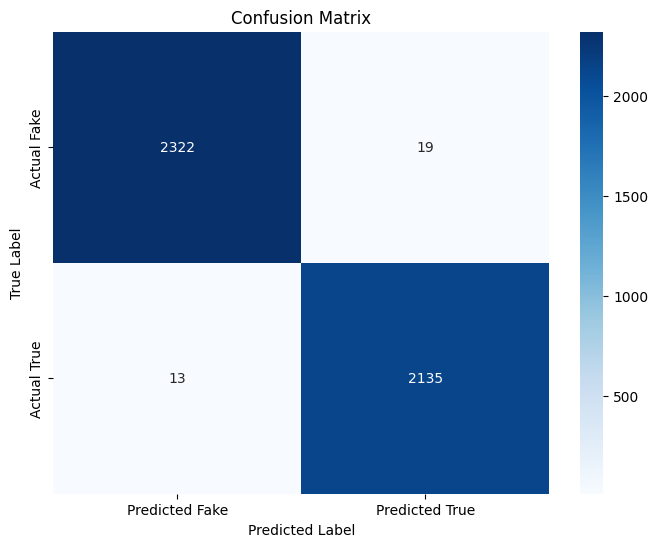

In [28]:
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fake', 'Predicted True'],
            yticklabels=['Actual Fake', 'Actual True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### the reults shows as that the model generelizes good in terms of accuracy with unseen data. Depedning on the context we were supposed to apply this model, we could optimize it or retrain it in order to minimize the number of false positives(specificity)

Next step, and final is to build a fastAPI to use the model for inference in new instances.